In [1]:
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
import time
import IPython.display as ipd #play audio
import keras
from keras import models, losses
from keras.models import Sequential
from keras.activations import relu, softmax
from keras.optimizers import Adam
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


Global params

In [2]:
LR = 0.0001
SR=44100
nObs=100

In [3]:
os.chdir("C:\\Users\\abc\\Documents\\deeplearning\\Audio")

In [4]:
train=pd.read_csv("train.csv")

In [5]:
train.head()

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1


In [6]:
train.label.value_counts().shape

(41,)

In [7]:
Y=train.label[:nObs]

Load audio files

In [8]:
wavFull=pd.DataFrame(pd.Series(range(0,2*SR)).rename('Index'))
tic=time.time()
os.chdir("C:\\Users\\abc\\Documents\\deeplearning\\Audio\\audio_train\\audio_train")
i=0
fileNames=[]
for filename in os.listdir(os.getcwd()):
    if i<nObs:
        #load wav file
        wav, _ = librosa.load(filename,sr=SR)
        #Grab only first 2 seconds
        wav=pd.Series(wav[:2*SR]).rename(i)
        wavFull=wavFull.join(wav)
        fileNames.append(filename)
        i+=1
wavFull=wavFull.transpose()
wavFull=wavFull.drop('Index',axis=0)
toc=time.time()
toc-tic

41.08935046195984

1 row for each audio file, 1 column for each sample

In [9]:
wavFull.shape

(100, 88200)

In [10]:
wavFull.head()

,0,1,2,3,4,5,6,7,8,9,...,88190,88191,88192,88193,88194,88195,88196,88197,88198,88199
0,0.000000,0.000793,-0.000153,-0.000366,-0.000244,-0.000488,-0.000916,-0.000275,0.000092,0.000519,...,-0.011353,-0.006714,0.003479,0.018158,0.029480,0.032440,0.027863,0.017395,0.006439,-0.000214
1,-0.001007,-0.000977,-0.001038,-0.001038,-0.001129,-0.001129,-0.001190,-0.001190,-0.001251,-0.001160,...,-0.157715,-0.161591,-0.163483,-0.161591,-0.155396,-0.146942,-0.139862,-0.138550,-0.144928,-0.157074
2,0.000000,0.000000,-0.000061,-0.000031,-0.000031,-0.000061,0.000000,0.000000,-0.000031,-0.000031,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.000000,0.000305,0.001190,-0.002014,-0.001495,0.000885,0.000122,-0.001740,-0.004059,-0.004822,...,-0.001556,-0.002197,-0.002869,-0.003448,-0.003906,-0.004211,-0.004547,-0.004791,-0.004852,-0.004852
4,-0.005280,-0.004944,-0.005249,-0.004333,-0.005188,-0.004242,-0.004242,-0.004059,-0.003540,-0.003662,...,0.131348,0.136749,0.145294,0.156555,0.167999,0.175232,0.179169,0.181946,0.180481,0.176361


Play audio file

In [11]:
ipd.Audio(fileNames[3])

Mel Spectogram

In [12]:
melspec = librosa.feature.melspectrogram(y=np.array(wavFull.iloc[3,:]), sr=SR)

time is represented in half seconds (i.e. time=2 is 1 second)

Text(0.5,1,'Glockenspiel')

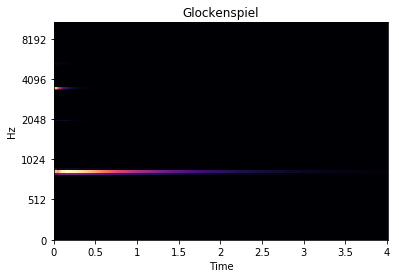

In [13]:
plt.figure()
librosa.display.specshow(melspec, y_axis='mel', x_axis='time')
plt.title(train.label[3])

In [14]:
melspec.shape

(128, 173)

In [15]:
128*173

22144

Mel spectogram creates 1 slice for 500 samples. size was 88200 x 1 = 88200, now is 128 x 173=22144, so reduces the dimensionality significantly. could probably handle audio length greater than 2 seconds

In [16]:
2*SR/173

509.8265895953757

In [17]:
wavFull.shape

(100, 88200)

Calculate mel spectogram for each audio file. store in 4D np array. replace NAs with 0s using np.nan_to_num, otherwise melspectogram function fails

In [18]:
tic=time.time()
i=0
for row in range(0,wavFull.shape[0]):
    if i<nObs:
        melspec = librosa.feature.melspectrogram(y=np.nan_to_num(np.array(wavFull.iloc[i,:])), sr=SR).reshape(1,128,173,1)
        if i==0:
            melFull=melspec
        else:
            melFull=np.concatenate((melFull,melspec),axis=0)
        i+=1
toc=time.time()
toc-tic

3.4351966381073

In [19]:
melFull.shape

(100, 128, 173, 1)

Scale x values to be between 0 and 1. In each image, we have a grid of intensity values that represent intensity for a given frequency for a given time. Regardless of which image, which frequency, or which time, we want these intensity values to be a percent from 0-100% intensity. So we look at the max and min across all dimesions of the dataset and use these max and min values to scale every value in the dataset.

In [20]:
x_max=melFull.max()
x_max

4083.9647197105337

In [21]:
x_min=melFull.min()
x_min

0.0

In [22]:
X=(melFull-x_min)/(x_max-x_min)

In [23]:
X.max()

1.0

In [25]:
X.min()

0.0

In [27]:
Y.head()

0          Hi-hat
1       Saxophone
2         Trumpet
3    Glockenspiel
4           Cello
Name: label, dtype: object

In [28]:
Y = pd.get_dummies(Y)

In [29]:
Y.shape

(100, 36)

In [30]:
nClass=Y.shape[1]

In [31]:
Y.head()

,Bark,Bass_drum,Burping_or_eructation,Bus,Cello,Chime,Clarinet,Computer_keyboard,Cough,Cowbell,...,Saxophone,Scissors,Shatter,Snare_drum,Squeak,Tambourine,Tearing,Telephone,Trumpet,Writing
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
X.shape

(100, 128, 173, 1)

In [33]:
Y.shape

(100, 36)

Model architecture

In [34]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=(128,173,1)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(nClass, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

Fit model

In [36]:
model.fit(X, Y, epochs=150, validation_split=0.2, shuffle=False, verbose=0)

In [37]:
model.evaluate(X,Y)

100/100 [==============================] - 3s 33ms/step


[2.6266321659088137, 0.76000000000000001]